# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [14:21, 211KB/s]                               
SVHN Training Set: 64.3MB [06:57, 154KB/s]                               


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

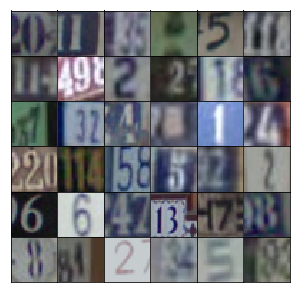

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), self.scaler(y)

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512, activation=None)
        x = tf.reshape(x, shape=(-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x*alpha, x)
        # 4*4*512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=(2,2), padding='same', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=training)
        conv1 = tf.maximum(conv1*alpha, conv1)
        # 8*8*256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=(2,2), padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.maximum(conv2*alpha, conv2)
        # 16*16*128
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(conv2, output_dim, 5, strides=(2,2), padding='same', activation=None)
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [ ]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 32, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(x1*alpha, x1)
        # 16*16*32
        
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(x2*alpha, x2)
        # 8*8*64
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(x3*alpha, x3)
        # 4*4*128
        
        x4 = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(x4, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 64
epochs = 1
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 2.3153
Epoch 1/1... Discriminator Loss: 8.8853... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.7206


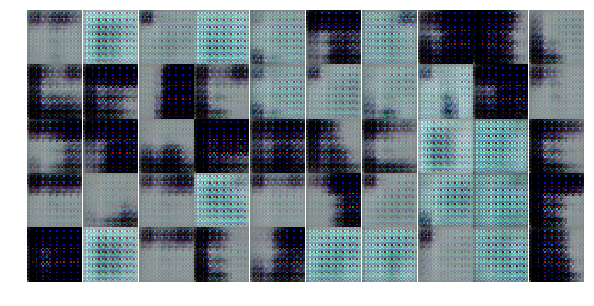

Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.7932
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.9421


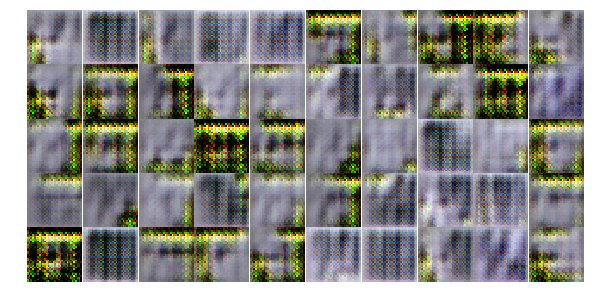

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 2.8417... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.1326


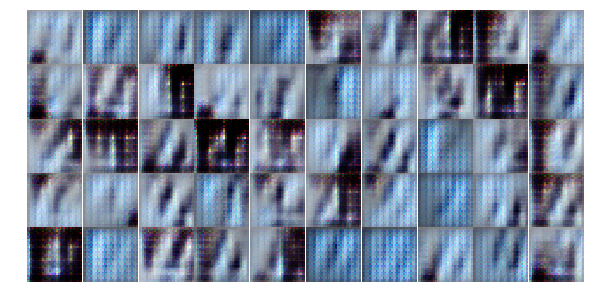

Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.5437


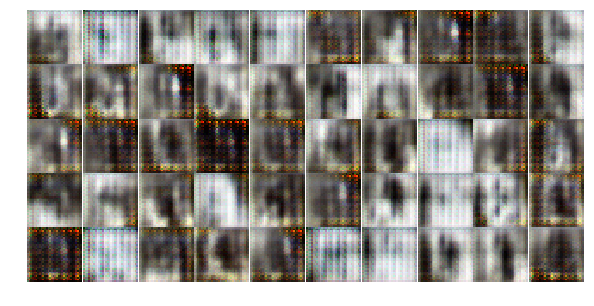

Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.6984


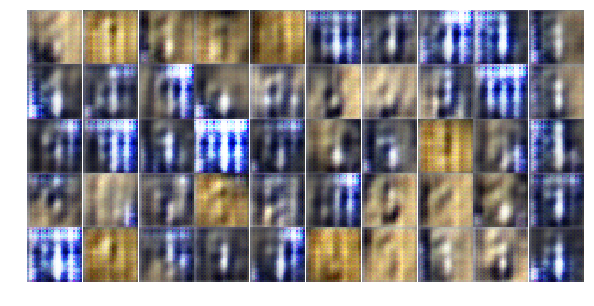

Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7778


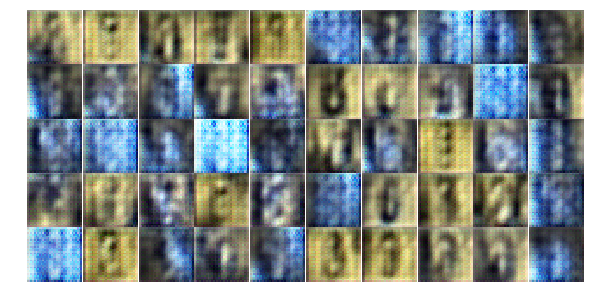

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7051


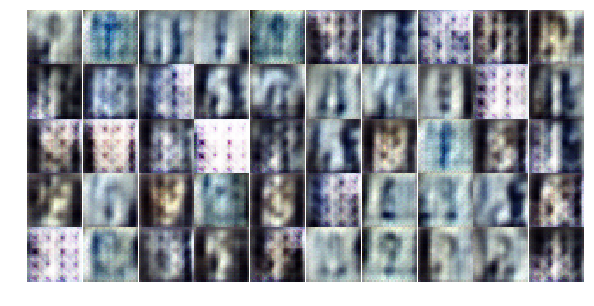

Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8073


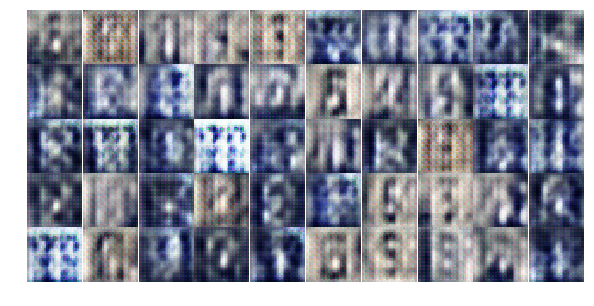

Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6365


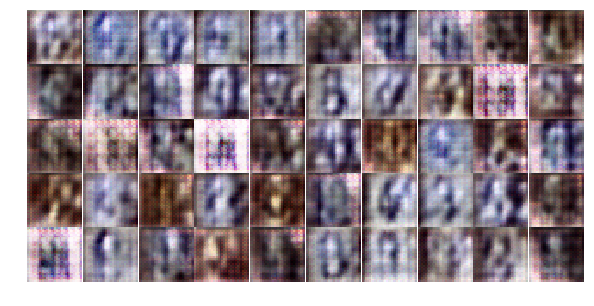

Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7632


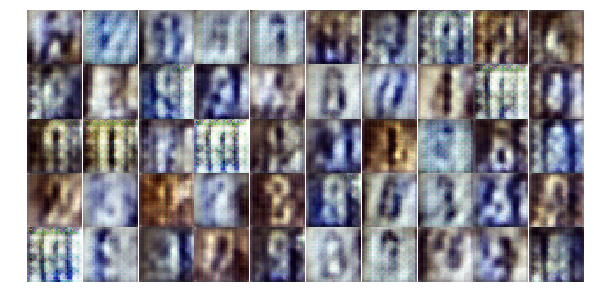

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.8435


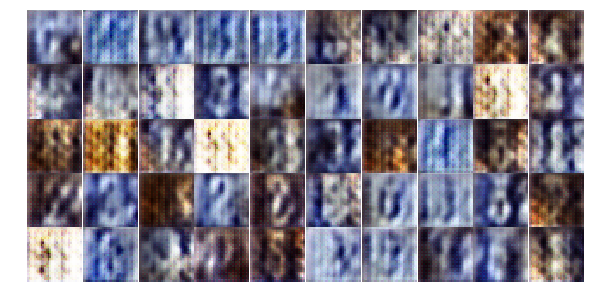

Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6838


In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

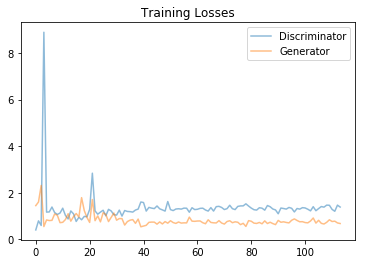

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

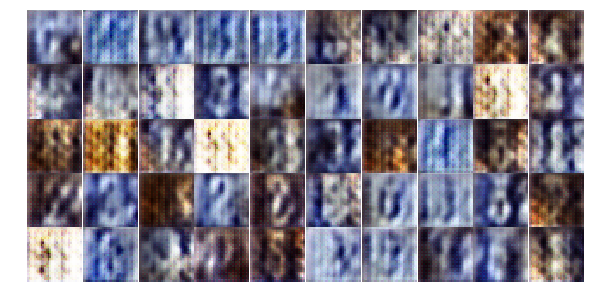

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))